### Rwanda Postprocessing

 **Disclaimer**: notebook in progress !

### _Options_

In [ ]:
from utils import *

In [54]:
## Options

# Folder
RESULTS_FOLDER = 'simulations_run_20250324_160931' # Name of the folder containing the results
DISPLAY = True # Usually set to False to avoid displaying the graphs

# Scenarios
SCENARIOS_RENAME = {
    'baseline': 'BaU',
}
selected_scenario = 'baseline'
scenario_order = ['baseline']

# Map file
EPM_TO_GEOJSON = {
    'South Africa': 'South_Africa',
    'Namibia': 'Namibia',
    'Mozambique': 'Mozambique',
    'United Republic of Tanzania': 'Tanzania',
    'Angola': 'Angola',
    'Botswana': 'Botswana',
    'Zambia': 'Zambia',
    'Malawi': 'Malawi',
    'Lesotho': 'Lesotho',
    'Zimbabwe': 'Zimbabwe',
    'Democratic Republic of the Congo': 'DRC',
}


# Option values 
DISCOUNT_RATE = 0.06
SELECT_XAXIS = [2026] # x-axis displayed range for the graphs

# Plot specifications
dict_specs = read_plot_specs()



In [55]:
# Create the folder path
RESULTS_FOLDER = os.path.join('..', 'output', RESULTS_FOLDER)
GRAPHS_RESULTS = 'img'
GRAPHS_RESULTS = os.path.join(RESULTS_FOLDER, GRAPHS_RESULTS)
if not os.path.exists(GRAPHS_RESULTS):
    os.makedirs(GRAPHS_RESULTS)
    print(f'Created folder {GRAPHS_RESULTS}')
print(f"Result folder: {RESULTS_FOLDER}")

Result folder: ..\output\simulations_run_20250324_160931


### _Read data_

In [56]:
# Extract and process EPM inputs
epm_input = extract_epm_folder(RESULTS_FOLDER, file='input.gdx')
epm_input = process_epm_inputs(epm_input, dict_specs, scenarios_rename=SCENARIOS_RENAME)
mapping_gen_fuel = epm_input['pGenDataExcel'].loc[:, ['scenario', 'generator', 'fuel']]

# Extract and process EPM results
epm_results = extract_epm_folder(RESULTS_FOLDER, file='epmresults.gdx')
epm_results = process_epm_results(epm_results, dict_specs, scenarios_rename=SCENARIOS_RENAME,
                                  mapping_gen_fuel=mapping_gen_fuel)

# Add plant colors to the dictionary
if False:
    temp = epm_results['pEnergyByPlant'].copy()
    plant_fuel_pairs = temp[['generator', 'fuel']].drop_duplicates()
    plant_fuel_pairs['colors'] = plant_fuel_pairs['fuel'].map(dict_specs['colors'])
    plant_to_color = dict(zip(plant_fuel_pairs['generator'], plant_fuel_pairs['colors']))
    dict_specs['colors'].update(plant_to_color)

Methane not defined as accepted techs. Please add it to `postprocessing/static/technologies.csv`.
annual_line_capa not in epm_results.keys().
pAnnualTransmissionCapacity not in epm_results.keys().
pFuelDispatch not in epm_results.keys().
InterconUtilization not in epm_results.keys().
pInterchange not in epm_results.keys().
Interchange not in epm_results.keys().
pInterconUtilization not in epm_results.keys().
AdditiononalCapacity_trans not in epm_results.keys().
pNPVByYear not in epm_results.keys().
pStorageComponents not in epm_results.keys().
InterchangeExtImp not in epm_results.keys().
interchanges not in epm_results.keys().
pCurtailedVRET not in epm_results.keys().
pCurtailedStoHY not in epm_results.keys().
pPlantFuelDispatch not in epm_results.keys().
pHourlyFlow not in epm_results.keys().
pFuelDispatch not found in epm_dict
pPlantFuelDispatch not found in epm_dict


### _Plotting figures - BaU scenario_

Mix

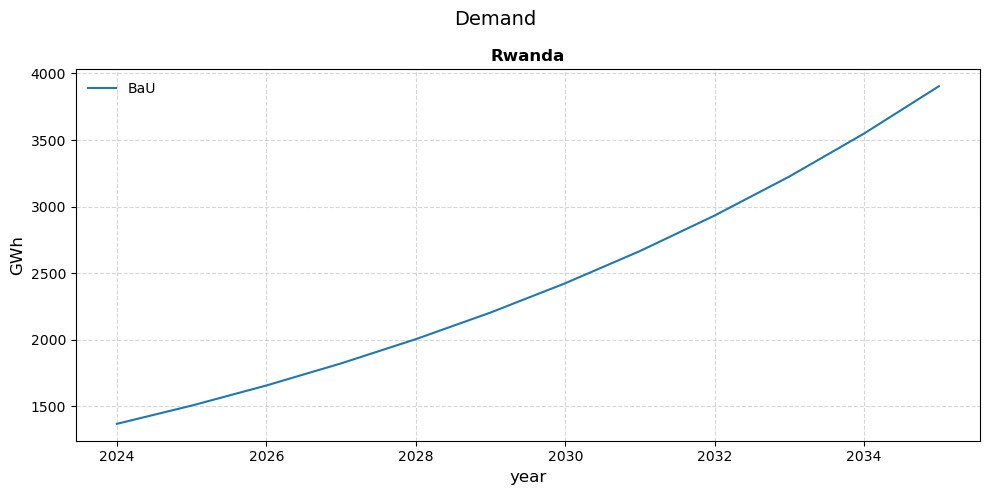

In [57]:
## Demand

# Options

# Plot 
df = epm_results['pDemandSupply'].copy()
df = df.loc[df['attribute']=='Demand: GWh']

make_line_subplots(
    df=df,
    filename='SystemCost_byZone.png',
    x_column='year',
    y_column='value',
    subplot_column='zone',
    group_column='scenario',
    dict_colors=dict_specs['colors'],
    format_y=lambda y, _: f"{y:.0f}",
    title='Demand', 
    ylabel = 'GWh'
)

c:\Users\wb590892\Documents\EPM_Models\Rwanda\EPM_local_v2\postprocessing\utils_git.py:1393: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby([x_column, stack_column])[y_column].sum().unstack(stack_column)


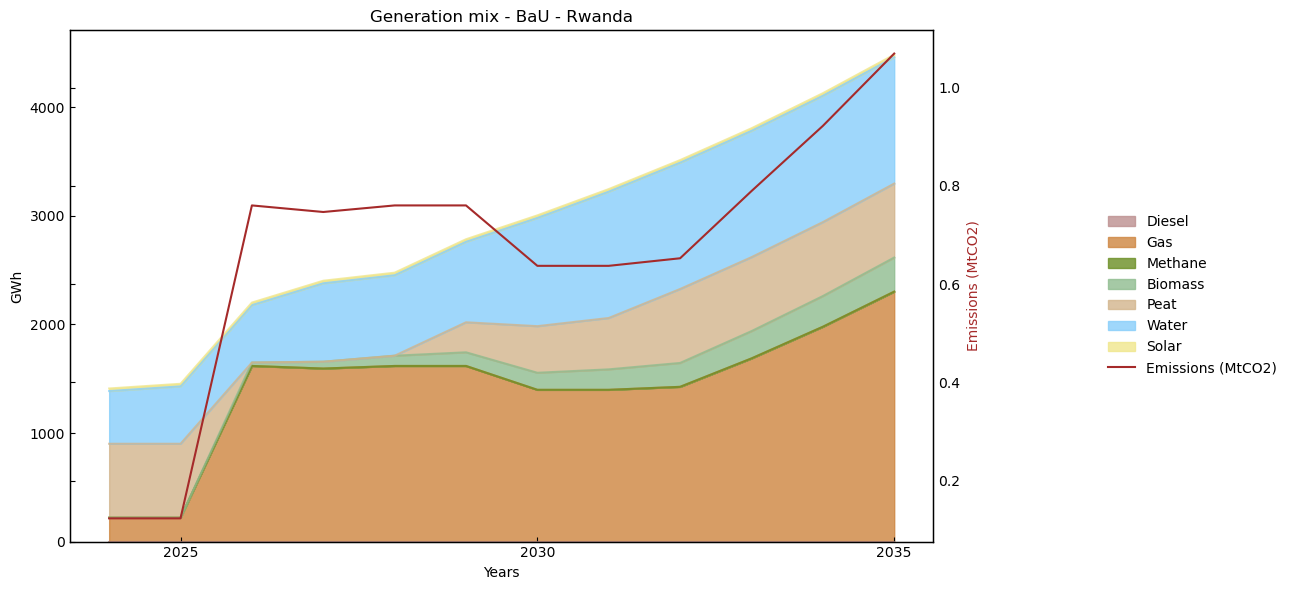

In [58]:
## Generation mix

# Options
scenario = 'BaU'
zone='Rwanda'
fuel_list_order = ['Diesel','Gas','Methane','Biomass','Peat', 'Water', 'Solar']
second_axis = 'Emissions'
#second_axis = 'Net imports'

# Plot 
df = epm_results['pEnergyByFuel'].copy()
df['fuel'] = pd.Categorical(df['fuel'], categories=fuel_list_order, ordered=True)

if second_axis == 'Emissions':
    df_2 = epm_results['pEmissions'].copy()

if second_axis == 'Net imports':
    df_2 = epm_results['pYearlyTrade']
    df_pivot = df_2.pivot(index=['scenario', 'zone', 'year'], columns='attribute', values='value').reset_index()
    df_pivot['Net imports'] = df_pivot['Imports'] - df_pivot['Exports']
    df_pivot = df_pivot[['scenario', 'year', 'zone', 'Net imports']]
    df_pivot.rename(columns={'Net imports': 'value'}, inplace=True)
    df_2 = df_pivot.copy()


for zone in list(df['zone'].unique()):
    df_zone = df.loc[(df['zone'] == zone)&(df['scenario'] == scenario)]
    filename = RESULTS_FOLDER+'/img/'+f'generation_mix_{scenario}_{zone}'
    stacked_area_plot(df_zone, x_column="year", y_column="value", stack_column="fuel", df_2=df_2, y2_label=f'Emissions (MtCO2)',
                      dict_colors=dict_specs['colors'], title=f'Generation mix - {scenario} - {zone}',
                      filename=False, y_label='GWh')
#    print(f'{zone} mix graph saved in {filename}')
    

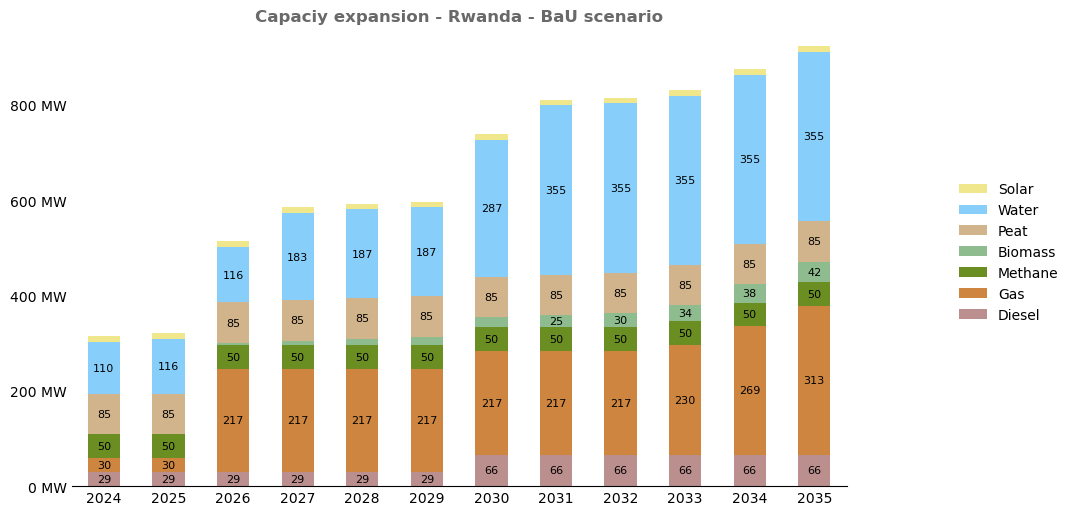

In [59]:
## Capacity mix

# Options
scenario = 'BaU'
zone='Rwanda'
fuel_list_order = ['Diesel','Gas','Methane','Biomass','Peat', 'Water', 'Solar']

# Plot
df = epm_results['pCapacityByFuel'].copy()
df['fuel'] = pd.Categorical(df['fuel'], categories=fuel_list_order, ordered=True)

make_stacked_bar_subplots(df, dict_colors=dict_specs['colors'],
                        column_xaxis='scenario', column_stacked='fuel', column_multiple_bars='year',
                        format_y=lambda y, _: '{:.0f} MW'.format(y), filename=None, title=f'Capaciy expansion - {zone} - {scenario} scenario', 
                        cap=25, fontsize_label=8, format_label="{:.0f}")

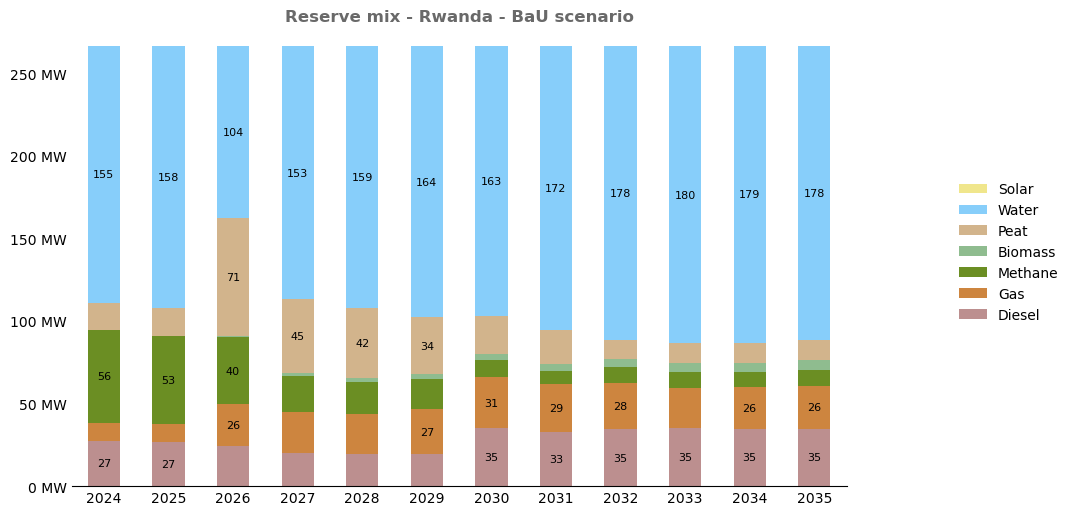

In [60]:
## Reserve mix

# Options
scenario = 'BaU'
zone='Rwanda'
fuel_list_order = ['Diesel','Gas','Methane','Biomass','Peat', 'Water', 'Solar']

# Plot
df = epm_results['pSpinningReserveByPlantZone'].copy()
df = df.drop(columns='generator').groupby(['scenario', 'zone', 'year', 'fuel']).sum().reset_index()
df['fuel'] = pd.Categorical(df['fuel'], categories=fuel_list_order, ordered=True)

make_stacked_bar_subplots(df, dict_colors=dict_specs['colors'],
                        column_xaxis='scenario', column_stacked='fuel', column_multiple_bars='year',
                        format_y=lambda y, _: '{:.0f} MW'.format(y), filename=None, title=f'Reserve mix - {zone} - {scenario} scenario', 
                        cap=25, fontsize_label=8, format_label="{:.0f}")

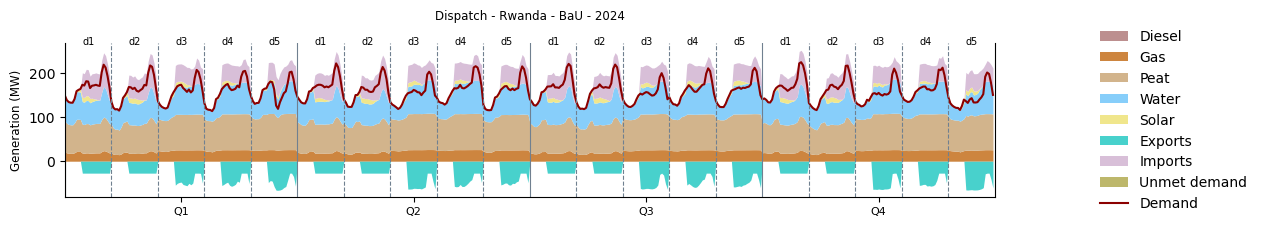

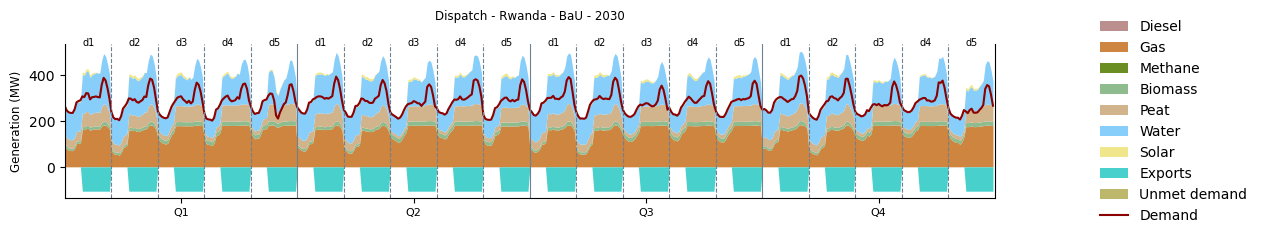

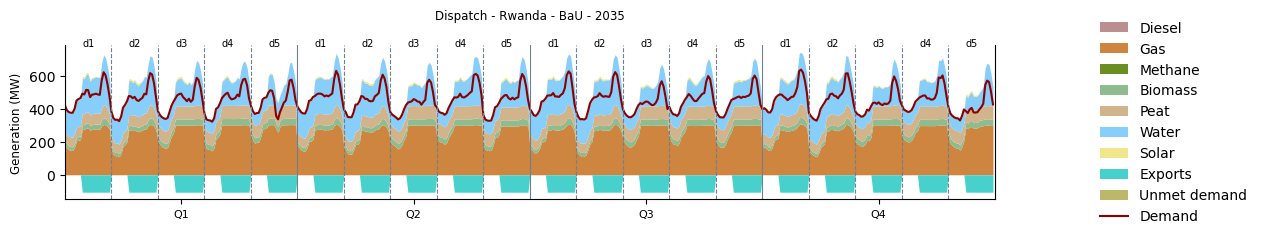

In [61]:
## Energy Dispatch 

# Options
year = 2035
scenario = 'BaU'
country = 'Rwanda'

# Plot
pPlantDispatch = epm_results['pPlantDispatch'].copy() 
pPlantDispatch['fuel'] = pd.Categorical(pPlantDispatch['fuel'], categories=fuel_list_order, ordered=True)

seasons = list(epm_results['pDispatch']['season'].unique())
days = list(epm_results['pDispatch']['day'].unique())
select_time = {'season': seasons, 'day': days}

dfs_to_plot_area = {
        'pPlantDispatch': filter_dataframe(pPlantDispatch, {'attribute': ['Generation']}),
        'pDispatch': filter_dataframe(epm_results['pDispatch'], {'attribute': ['Unmet demand', 'Exports', 'Imports', 'Storage Charge']})
    }

dfs_to_plot_line = {
        'pDispatch': filter_dataframe(epm_results['pDispatch'], {'attribute': ['Demand']})
    }

for year in [2024, 2030, 2035]:
    make_complete_fuel_dispatch_plot(dfs_to_plot_area, dfs_to_plot_line, dict_specs['colors'],
                                                    zone=zone, year=year, scenario=scenario,
                                                    fuel_grouping=None, select_time=select_time,
                                                    bottom=None, legend_loc='right', figsize=(12,2), title=f'Dispatch - {country} - {scenario} - {year}')


C:\Users\wb590892\AppData\Local\Temp\ipykernel_25516\1850083105.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_reserve = df_reserve.drop(columns=['generator', 'fuel', 'attribute']).groupby(['scenario', 'zone', 'year', 'season', 'day', 't']).sum().reset_index()


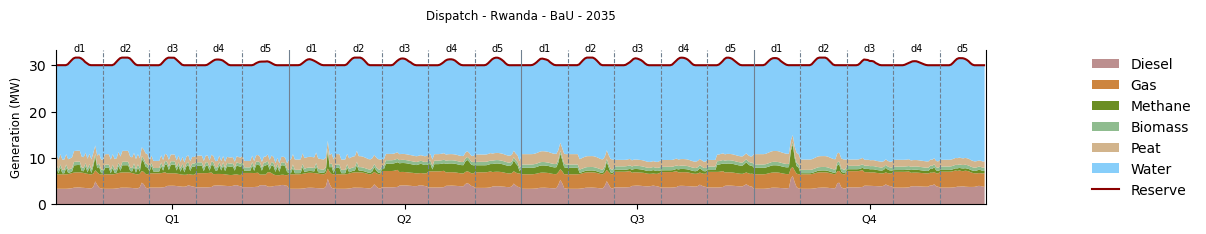

In [62]:
## Energy Dispatch 

# Options
year = 2035
scenario = 'BaU'
country = 'Rwanda'

# Plot
pPlantDispatch = epm_results['pPlantDispatch'].copy() 
pPlantDispatch['fuel'] = pd.Categorical(pPlantDispatch['fuel'], categories=fuel_list_order, ordered=True)

df_reserve = pPlantDispatch.loc[pPlantDispatch['attribute']=='Reserve']
df_reserve = df_reserve.drop(columns=['generator', 'fuel', 'attribute']).groupby(['scenario', 'zone', 'year', 'season', 'day', 't']).sum().reset_index()
df_reserve['attribute'] = 'Reserve'
epm_results['pDispatchReserve'] = df_reserve

seasons = list(epm_results['pDispatch']['season'].unique())
days = list(epm_results['pDispatch']['day'].unique())
select_time = {'season': seasons, 'day': days}

dfs_to_plot_area = {
        'pPlantDispatch': filter_dataframe(pPlantDispatch, {'attribute': ['Reserve']})
    }

dfs_to_plot_line = {
        'pDispatchReserve': filter_dataframe(epm_results['pDispatchReserve'], {'attribute': ['Reserve']})
    }

make_complete_fuel_dispatch_plot(dfs_to_plot_area, dfs_to_plot_line, dict_specs['colors'],
                                                 zone=zone, year=year, scenario=scenario,
                                                 fuel_grouping=None, select_time=select_time,
                                                 bottom=None, legend_loc='right', figsize=(12,2), title=f'Dispatch - {country} - {scenario} - {year}')

Costs

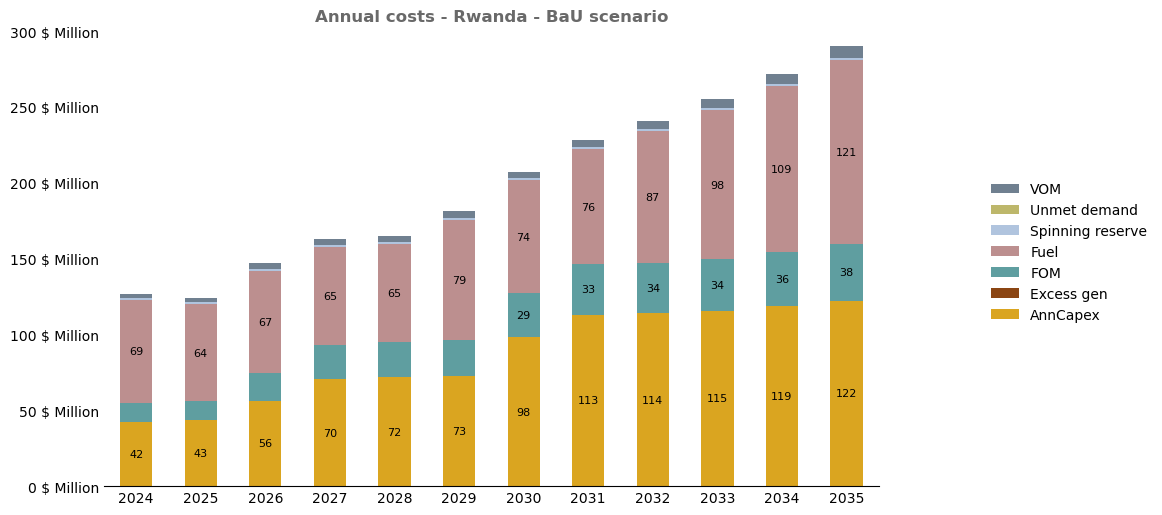

In [63]:
## Costs 

# Options
scenario = 'BaU'
zone='Rwanda'
fuel_list_order = ['Diesel','Gas','Methane','Biomass','Peat', 'Water', 'Solar']

# Plot
selected_costs =  ['Annualized capex: $m',
 'Fixed O&M: $m',
 'Variable O&M: $m',
 'Total fuel Costs: $m',
 'Transmission additions: $m',
 'Unmet demand costs: $m',
 'Excess generation: $m',
 'VRE curtailment: $m',
 #'Import costs: $m',
 #'Export revenue: $m', 
 'Spinning Reserve costs: $m']

selected_names = ['AnnCapex', 'FOM', 'VOM', 'Fuel', 'Transmissions', 'Unmet demand', 'Excess gen', 'VRE curtail', 'Spinning reserve']
name_mapping = dict(zip(selected_costs, selected_names))

df = epm_results['pCostSummary'].copy()
df = df.loc[df['attribute'].isin(selected_costs)]
df['attribute'] = df['attribute'].replace(name_mapping)
df['value'] = df['value'].copy() # / 1000 # US$ Million to US$ Billion


# pCostSummary_select['value_discounted'] = pCostSummary_select.apply(lambda row: row['value'] * pRR[row['year']], axis=1)
# pCostSummary_select['value_weighted_discounted'] = pCostSummary_select.apply(lambda row: row['value_discounted'] * pWeightYears[row['year']], axis=1)
# pCostSummary_select['value_weighted_undiscounted'] = pCostSummary_select.apply(lambda row: row['value'] * pWeightYears[row['year']], axis=1)


make_stacked_bar_subplots(df, dict_colors=dict_specs['colors'],
                        column_xaxis='scenario', column_stacked='attribute', column_multiple_bars='year',
                        format_y=lambda y, _: '{:.0f} $ Million'.format(y), filename=None, title=f'Annual costs - {zone} - {scenario} scenario', 
                        cap=25, fontsize_label=8, format_label="{:.0f}")

Trade

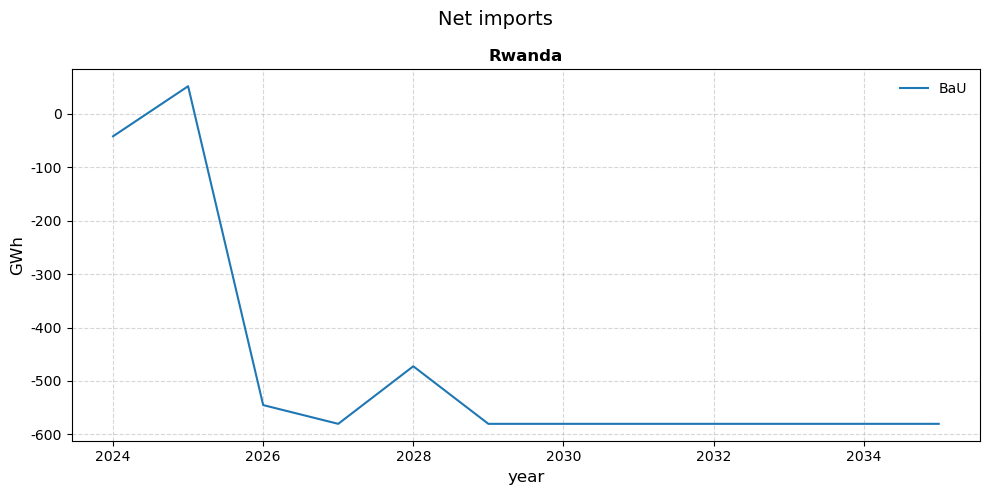

In [64]:
## Net imports

# Options

# Plot 
df = epm_results['pYearlyTrade']
df_pivot = df.pivot(index=['scenario', 'zone', 'year'], columns='attribute', values='value').reset_index()
df_pivot.fillna(0, inplace=True)
df_pivot['Net imports'] = df_pivot['Imports'] - df_pivot['Exports']
df_pivot = df_pivot[['scenario', 'year', 'zone', 'Net imports']]

make_line_subplots(
    df=df_pivot,
    filename='SystemCost_byZone.png',
    x_column='year',
    y_column='Net imports',
    subplot_column='zone',
    group_column='scenario',
    dict_colors=dict_specs['colors'],
    format_y=lambda y, _: f"{y:.0f}",
    title='Net imports', 
    ylabel = 'GWh'
)


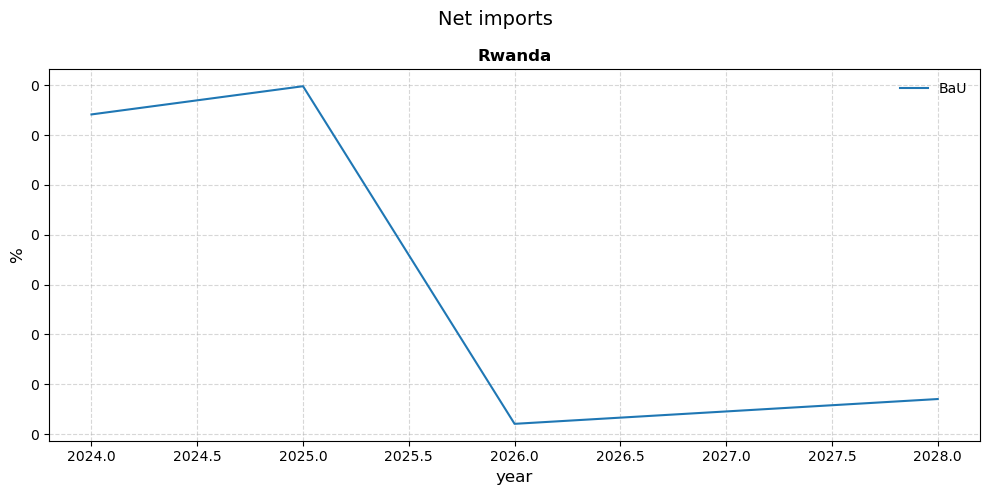

In [65]:
## Import share

# Options

# Plot 
pYearlyTrade = epm_results['pYearlyTrade'].copy()
pEnergyByFuel = epm_results['pEnergyByFuel'].copy()

pYearlyGeneration = pEnergyByFuel.drop(columns='fuel').groupby(['scenario', 'zone', 'year']).sum().reset_index()
pYearlyImports = pYearlyTrade.loc[pYearlyTrade['attribute']=='Imports']
pYearlyExports = pYearlyTrade.loc[pYearlyTrade['attribute']=='Exports']

df = pd.merge(pYearlyGeneration, pYearlyImports, on=['scenario', 'zone', 'year'], how='inner', suffixes=('_generation', '_import'))
df['import_share'] = df['value_import'] / df['value_generation']
df = df[['scenario', 'zone', 'year','import_share']]

make_line_subplots(
    df=df,
    filename='SystemCost_byZone.png',
    x_column='year',
    y_column='import_share',
    subplot_column='zone',
    group_column='scenario',
    dict_colors=dict_specs['colors'],
    format_y=lambda y, _: f"{y:.0f}",
    title='Net imports', 
    ylabel = '%'
)

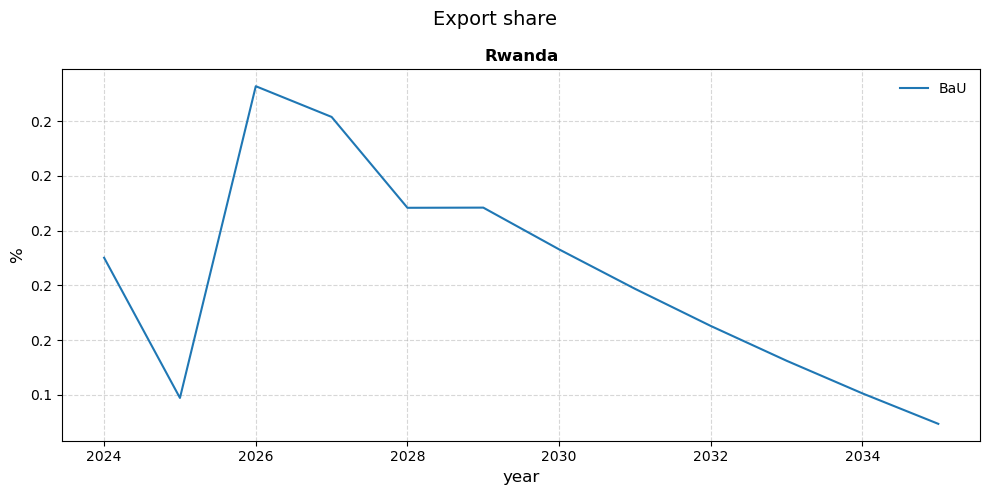

In [66]:
## Export share

# Options

# Plot 
pYearlyTrade = epm_results['pYearlyTrade'].copy()
pEnergyByFuel = epm_results['pEnergyByFuel'].copy()

pYearlyGeneration = pEnergyByFuel.drop(columns='fuel').groupby(['scenario', 'zone', 'year']).sum().reset_index()
pYearlyImports = pYearlyTrade.loc[pYearlyTrade['attribute']=='Imports']
pYearlyExports = pYearlyTrade.loc[pYearlyTrade['attribute']=='Exports']

df = pd.merge(pYearlyGeneration, pYearlyExports, on=['scenario', 'zone', 'year'], how='inner', suffixes=('_generation', '_export'))
df['export_share'] = df['value_export'] / df['value_generation']
df = df[['scenario', 'zone', 'year','export_share']]

make_line_subplots(
    df=df,
    filename='SystemCost_byZone.png',
    x_column='year',
    y_column='export_share',
    subplot_column='zone',
    group_column='scenario',
    dict_colors=dict_specs['colors'],
    format_y=lambda y, _: f"{y:.1f}",
    title='Export share', 
    ylabel = '%'
)